In [129]:
import pandas as pd
import numpy as np

In [130]:
train = pd.read_csv('dataset/cleaned_train.csv')

In [131]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0
1,000103f0d9cfb60f,match background colour seemingli stuck thank ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man realli tri edit war guy constantli rem...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggest improv wonder section statis...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chanc rememb page,0,0,0,0,0,0


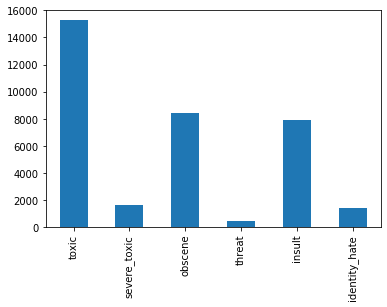

In [132]:
train[[ 'toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']].sum().plot(kind='bar')

In [133]:
y = train[[ 'toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]

In [134]:
train.comment_text.map(lambda x: len(x)).describe()

count    159571.000000
mean        122.525735
std          87.844315
min           1.000000
25%          48.000000
50%         104.000000
75%         191.000000
max         400.000000
Name: comment_text, dtype: float64

In [135]:
def cut_text(x):
    if len(x) > 200:
        return x[:200]
    return x

In [136]:
train['comment_text'] = train.comment_text.map(lambda x: cut_text(x))

In [137]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [145]:
count_vect = CountVectorizer(max_features=30000)

In [146]:
train_text = (train['comment_text'])
test_text = (test['comment_text'])
X_train_counts = count_vect.fit_transform(train_text)

In [148]:
from sklearn.feature_extraction.text import TfidfTransformer

In [149]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(159571, 30000)

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tf, y, test_size=0.3, random_state=0)

In [151]:
X_train.shape

(111699, 30000)

Training a classifier

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [153]:
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

In [154]:
model = multi_target_forest.fit(X_train, y_train)

In [155]:
res = model.predict(X_test)

In [156]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

In [157]:
roc_auc_score(y_test, res)

0.674227350987826

In [158]:
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.88      0.62      0.73      4591
           1       0.47      0.07      0.12       485
           2       0.87      0.69      0.77      2527
           3       0.64      0.07      0.12       131
           4       0.78      0.53      0.63      2362
           5       0.71      0.13      0.22       430

   micro avg       0.85      0.57      0.68     10526
   macro avg       0.73      0.35      0.43     10526
weighted avg       0.83      0.57      0.66     10526
 samples avg       0.06      0.05      0.05     10526



C:\Users\22169\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\22169\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save and test model

In [159]:
from joblib import dump, load

In [160]:
dump(multi_target_forest, 'models/random_forest/RF_model.joblib') 

['models/random_forest/RF_model.joblib']

In [161]:
import pickle

In [162]:
with open('models/random_forest/CV.pkl', 'wb') as fout:
    pickle.dump((count_vect, tf_transformer, multi_target_forest), fout)

In [163]:
with open('models/random_forest/CV.pkl', 'rb') as f:
   CV, TTF, RF_model = pickle.load(f)

In [164]:
test = pd.read_csv('dataset/cleaned_test.csv')
label = pd.read_csv('dataset/test_labels.csv')

In [165]:
test_text = test.comment_text

In [166]:
X_test_counts = CV.fit_transform(test_text)

In [167]:
tf_test_transformer = TTF.fit(X_test_counts)
X_test_tf = tf_test_transformer.transform(X_test_counts)

In [170]:
pred = RF_model.predict(X_test_tf)

In [173]:
pred

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [174]:
sample_submission = pd.read_csv('dataset/sample_submission.csv')
sample_submission[[ 'toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']] = pred

In [175]:
sample_submission.to_csv('mnb_submission.csv', index=False)